In [1]:
import os
import ruamel.yaml as yaml
import matplotlib.pyplot as plt
import numpy as np

## Obligatory paths

In [2]:
path_to_local_folder = os.path.expanduser('~/charon_local')
filter_include = ["synth", "A04hm_H1", "nocond","synth_A04hm_H1_nocond_20230419"]
filter_exclude = ["failed"]

conf_name = "config_mcmc_bayes.yaml"

# načtení dat a formatovani dat

In [3]:
from raw_data import MultiRawData
from raw_data import get_subfolder_paths_processed, filter_datasets

subfolders = get_subfolder_paths_processed(path_to_local_folder)
subfolders_filt = filter_datasets(subfolders, filter_include, filter_exclude)

all_raw_data = MultiRawData()
all_raw_data.load_from_folders_hdf5(subfolders_filt)

# load yaml config from the first folder in the list, it will be used for likelihood evaluation
conf = yaml.safe_load(open(os.path.join(subfolders_filt[0], conf_name), 'r'))
subfolders_filt


['/home/ber0061/charon_local/borehole_H1/synth_A04hm_H1_nocond_20230419']

## Filtrovaní dat

In [4]:
# filter data so only those with model are used and only ones with tag 1 = coverged
raw_data_filtered = all_raw_data.filter(types=[0, 2], tags=[1])
raw_data_filtered.print_statistics()

raw data: no_samples 21069
raw data: no_nonconverging 0
raw data: p (21069, 8)
raw data: w (21069, 1)
raw_data: np.sum(weights): 492669.0
raw_data: all_sizes: {'types': (21069,), 'stages': (21069,), 'chains': (21069,), 'tags': (21069,), 'parameters': (21069, 8), 'observations': (21069, 26), 'parameters_normalized': (21069, 8), 'weights': (21069, 1), 'run_ids': (21069,)}


## Rekonstrukce modelu šumu pro výpočet likelihoodu

In [5]:
import surrDAMH_gaussian_process as gp

def compute_log_likelihood_all(data):
    # reconstruct covariance of the noise
    cov_mat = gp.assemble_covariance_matrix(conf['noise_model'])

    # rewritten likelihood for our model
    def get_log_likelihood_multivariate(observations, G_sample,noise_std):
        v = observations - G_sample.ravel()
        invCv = np.linalg.solve(noise_std,v)
        return -0.5*np.dot(v,invCv)

    # measurement from conf
    y_orig = np.array(conf['problem_parameters']['observations'])

    log_likelihood = np.zeros((data.shape[0],1))
    for idx,obs in enumerate(data):
        log_likelihood[idx] = get_log_likelihood_multivariate(obs,y_orig,cov_mat)
    
    return log_likelihood

## Vytvoření datasetu pro trénování a testování

In [6]:
data = raw_data_filtered.parameters_normalized
obs = raw_data_filtered.observations

obs_likelihood = compute_log_likelihood_all(obs)


9.357622968840175e-14 2.061153622438558e-09 4.5399929762484854e-05 0.01831563888873418


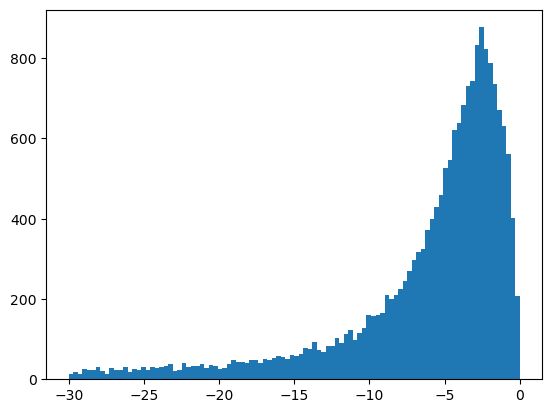

In [23]:
_ = plt.hist(obs_likelihood, bins=100, range=(-30, 0))
print(np.exp(-30), np.exp(-20), np.exp(-10), np.exp(-4))

In [31]:
# filter only data and obs with obs_likelihood > -10
data_filt = data[obs_likelihood.ravel() > -10, :]  # type: ignore
obs_filt = obs[obs_likelihood.ravel() > -10, :]  # type: ignore
obs_filt.shape

(15518, 26)

In [32]:

from sklearn.model_selection import train_test_split

input_data = data_filt
output_data = obs_filt

# rozdělit data na trénovací a testovací set
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.5, random_state=42)

likelihood_train = compute_log_likelihood_all(y_train)
likelihood_test = compute_log_likelihood_all(y_test)
likelihood_train.shape

(7759, 1)

In [33]:
# simulace acceptance probability

def acceptance_prob_all(prediction_likelihood):
    # create random permutation of filt_likelihood,acc_likelihood
    idx = np.random.permutation(len(prediction_likelihood))
    old_pred = prediction_likelihood[idx]
    old_test = likelihood_test[idx]

    alpha_s = np.minimum(likelihood_test + old_pred - prediction_likelihood - old_test,0)

    return np.exp(alpha_s)

In [34]:
def plot_results_only_likelihood(res_surr):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # First subplot
    axs[0].scatter(likelihood_test, res_surr, alpha=0.1, marker='.')
    axs[0].plot([-10,0],[-10,0], color='red')
    axs[0].set_ylim(-10, 0)
    axs[0].set_xlim(-10, 0)

    # Second subplot
    alpha_all = acceptance_prob_all(res_surr)
    axs[1].hist(alpha_all)
    mean_acceptance = np.mean(alpha_all)
    axs[1].set_title(f'mean acceptance = {mean_acceptance}')
    plt.show()


def plot_results_all(res_surr):
    plot_results_only_likelihood(compute_log_likelihood_all(res_surr))

## Polynomial model from sklearn

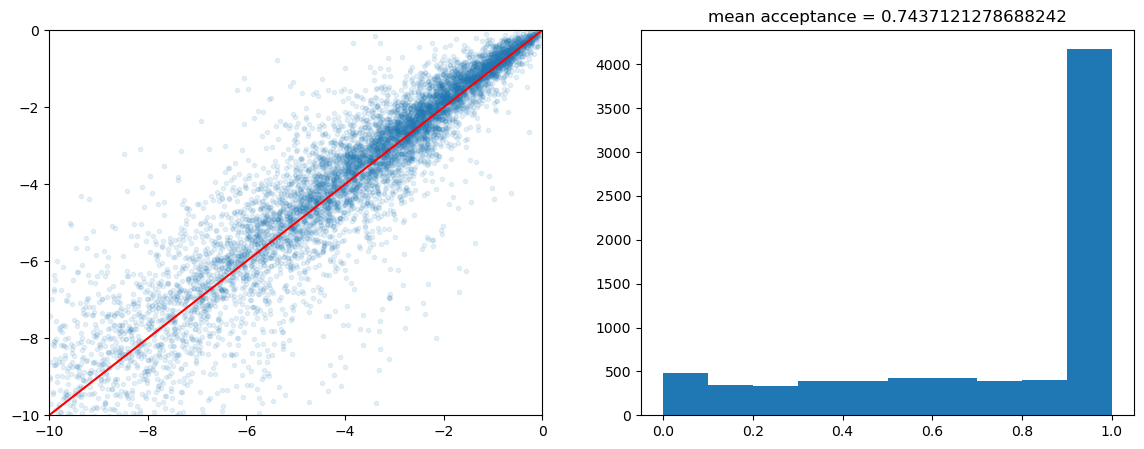

In [41]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def polynomial_regression(X, y, degree):
    # Create a pipeline that first creates polynomial features and then fits a linear regression model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)
    return model

tmp = polynomial_regression(X_train, y_train,5)
res_surr = tmp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)


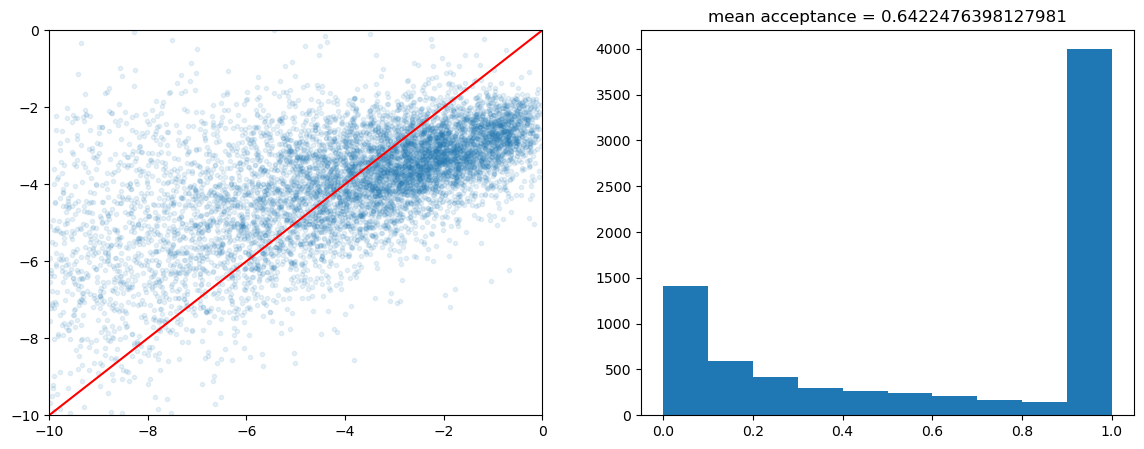

In [42]:
tmp = polynomial_regression(X_train, likelihood_train,3)
res_surr = tmp.predict(X_test)

# compute alphas and plot results
plot_results_only_likelihood(res_surr)


## RBF pomocí scipy

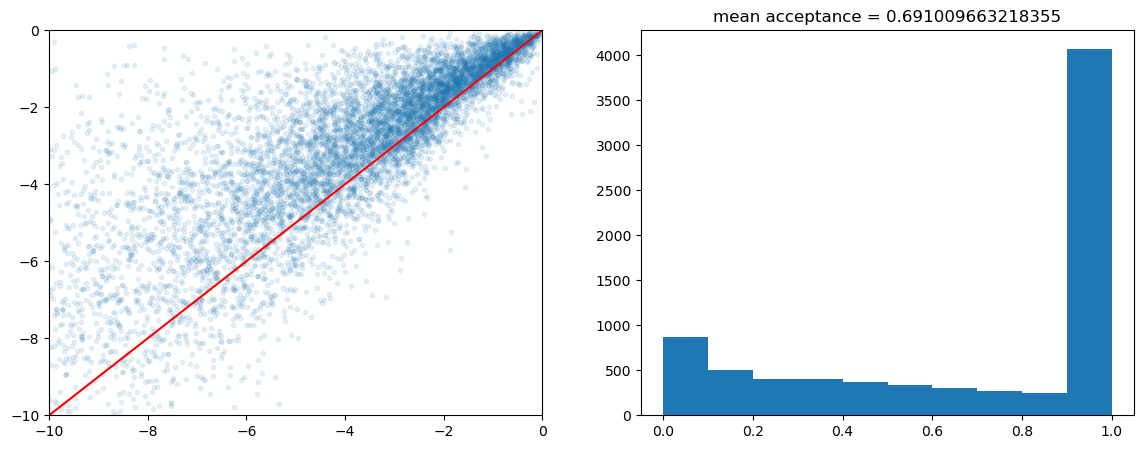

In [43]:
from scipy.interpolate import RBFInterpolator

# Použití funkce surrogate_model
"""    kernel: typ jaderné funkce ('linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 
             'inverse_multiquadric', 'inverse_quadratic', 'gaussian')"""
tmp = RBFInterpolator(X_train, y_train, kernel='linear')
res_surr = tmp(X_test)


# compute alphas and plot results
plot_results_all(res_surr)

## více typů RBF v scipy
obdobná implementace, ale scipy je rychlejší

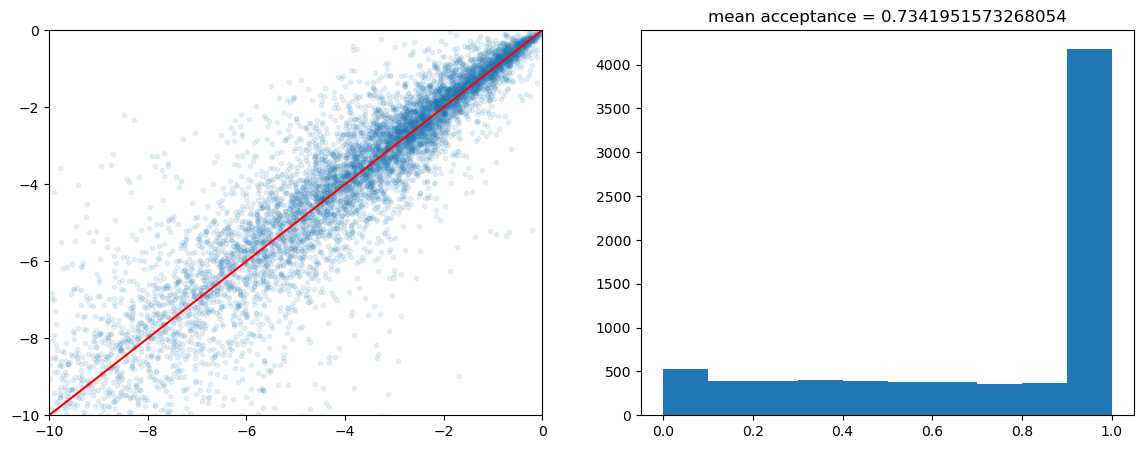

In [47]:
# Použití funkce surrogate_model
"""    kernel: typ jaderné funkce ('linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 
             'inverse_multiquadric', 'inverse_quadratic', 'gaussian')"""

tmp = RBFInterpolator(X_train, y_train, kernel='inverse_quadratic', degree=3, epsilon=1)
res_surr = tmp(X_test)


# compute alphas and plot results
plot_results_all(res_surr)

# Zkouška pomocí neural network v sklearn

Iteration 1, loss = 4489.80906805
Iteration 2, loss = 4450.97259318
Iteration 3, loss = 4379.67649672
Iteration 4, loss = 4256.06834943
Iteration 5, loss = 4070.41390303
Iteration 6, loss = 3826.81498429
Iteration 7, loss = 3541.11638423
Iteration 8, loss = 3234.70856683
Iteration 9, loss = 2927.90311457
Iteration 10, loss = 2637.97558414
Iteration 11, loss = 2376.33222861
Iteration 12, loss = 2147.13579743
Iteration 13, loss = 1950.72861437
Iteration 14, loss = 1784.55200385
Iteration 15, loss = 1643.81412949
Iteration 16, loss = 1523.95559122
Iteration 17, loss = 1420.42968391
Iteration 18, loss = 1329.37712492
Iteration 19, loss = 1248.10512774
Iteration 20, loss = 1174.46204004
Iteration 21, loss = 1107.39179726
Iteration 22, loss = 1045.39453372
Iteration 23, loss = 988.02202592
Iteration 24, loss = 934.61214229
Iteration 25, loss = 884.62024006
Iteration 26, loss = 837.75849352
Iteration 27, loss = 793.91052357
Iteration 28, loss = 752.53931939
Iteration 29, loss = 713.72808234
I

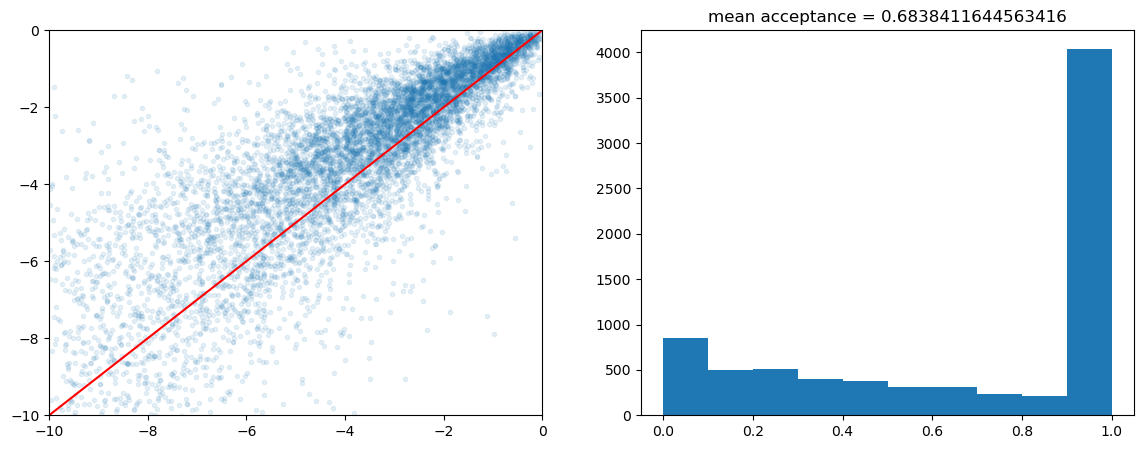

In [48]:
from sklearn.neural_network import MLPRegressor

# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(50,),activation='relu', solver='adam', max_iter=50000, verbose=True)

# trénovat model
mlp.fit(X_train, y_train)


res_surr = mlp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)

Iteration 1, loss = 3873.15443534
Iteration 2, loss = 1112.01806503
Iteration 3, loss = 349.13069473
Iteration 4, loss = 224.83921399
Iteration 5, loss = 199.82874092
Iteration 6, loss = 185.56352674
Iteration 7, loss = 176.66554923
Iteration 8, loss = 170.96311427
Iteration 9, loss = 166.85415904
Iteration 10, loss = 163.90413118
Iteration 11, loss = 161.65422236
Iteration 12, loss = 159.62142832
Iteration 13, loss = 157.74852040
Iteration 14, loss = 156.08818474
Iteration 15, loss = 154.36233913
Iteration 16, loss = 152.32242173
Iteration 17, loss = 150.78134150
Iteration 18, loss = 148.57259746
Iteration 19, loss = 146.43938314
Iteration 20, loss = 144.33183111
Iteration 21, loss = 142.13348510
Iteration 22, loss = 139.91726592
Iteration 23, loss = 137.51176520
Iteration 24, loss = 135.87587302
Iteration 25, loss = 133.68442640
Iteration 26, loss = 131.35324011
Iteration 27, loss = 129.50688144
Iteration 28, loss = 127.42527132
Iteration 29, loss = 125.31744334
Iteration 30, loss = 

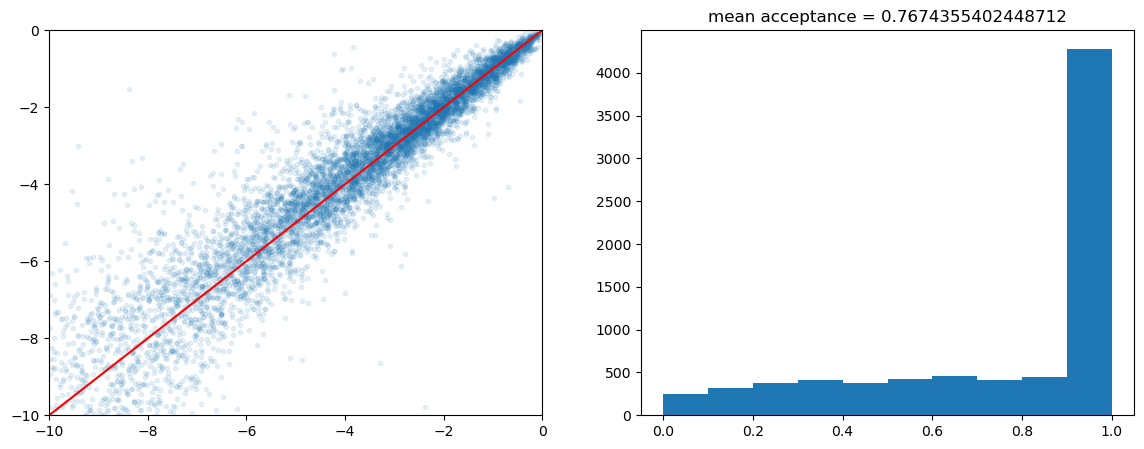

In [49]:
# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(500,500),activation='relu', solver='adam', max_iter=50000, verbose=True)

# trénovat model
mlp.fit(X_train, y_train)


res_surr = mlp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)

Iteration 1, loss = 4305.82797227
Iteration 2, loss = 1954.05427774
Iteration 3, loss = 462.47295674
Iteration 4, loss = 241.66700459
Iteration 5, loss = 207.63249405
Iteration 6, loss = 190.37347516
Iteration 7, loss = 178.88195716
Iteration 8, loss = 171.62417987
Iteration 9, loss = 167.21490830
Iteration 10, loss = 164.77664425
Iteration 11, loss = 163.34017349
Iteration 12, loss = 162.14925685
Iteration 13, loss = 160.93402294
Iteration 14, loss = 160.20482809
Iteration 15, loss = 159.29785217
Iteration 16, loss = 158.72510212
Iteration 17, loss = 157.69170364
Iteration 18, loss = 156.87498439
Iteration 19, loss = 156.07948584
Iteration 20, loss = 155.22073696
Iteration 21, loss = 154.43415819
Iteration 22, loss = 153.57599495
Iteration 23, loss = 152.65216048
Iteration 24, loss = 151.80794642
Iteration 25, loss = 150.89633668
Iteration 26, loss = 149.67307273
Iteration 27, loss = 148.78049825
Iteration 28, loss = 147.53836057
Iteration 29, loss = 146.42774418
Iteration 30, loss = 

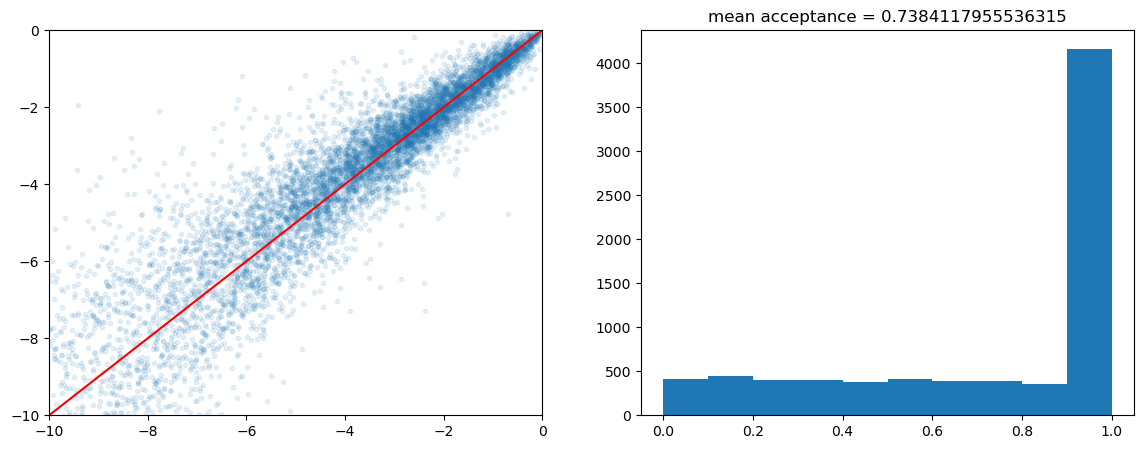

In [50]:
# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(64, 128, 128), activation='relu', solver='adam', max_iter=50000, verbose=True)

# trénovat model
mlp.fit(X_train, y_train)


res_surr = mlp.predict(X_test)

# compute alphas and plot results
plot_results_all(res_surr)


# pytorch


Epoch [1/50000], Loss: 308.3962, min Loss reached inf, stagnating for 0 it.
Epoch [2/50000], Loss: 316.5718, min Loss reached 308.3962, stagnating for 0 it.
Epoch [3/50000], Loss: 223.4681, min Loss reached 308.3962, stagnating for 1 it.
Epoch [4/50000], Loss: 145.2943, min Loss reached 223.4681, stagnating for 0 it.
Epoch [5/50000], Loss: 177.9894, min Loss reached 145.2943, stagnating for 0 it.
Epoch [6/50000], Loss: 122.2889, min Loss reached 145.2943, stagnating for 1 it.
Epoch [7/50000], Loss: 70.1200, min Loss reached 122.2889, stagnating for 0 it.
Epoch [8/50000], Loss: 37.5493, min Loss reached 70.1200, stagnating for 0 it.
Epoch [9/50000], Loss: 74.4048, min Loss reached 37.5493, stagnating for 0 it.
Epoch [10/50000], Loss: 57.7710, min Loss reached 37.5493, stagnating for 1 it.
Epoch [11/50000], Loss: 33.8152, min Loss reached 37.5493, stagnating for 2 it.
Epoch [12/50000], Loss: 36.2063, min Loss reached 33.8152, stagnating for 0 it.
Epoch [13/50000], Loss: 33.7553, min Loss

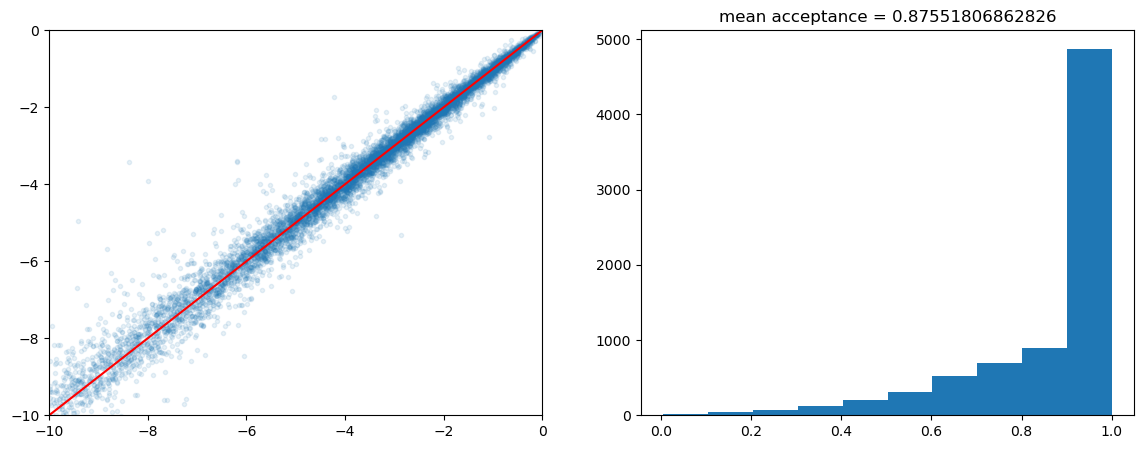

In [63]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Creating a simple neural network in PyTorch


class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x



# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader for the training set
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # Adjust the batch size

# Create the model
model = Net(X_train.shape[1], y_train.shape[1])

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Decrease the learning rate

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

# Train the model
num_epochs = 50000
best_loss = np.inf
patience, trials = 1000, 0

for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Adjust the learning rate based on the loss
    scheduler.step(loss)

    print('Epoch [{}/{}], Loss: {:.4f}, min Loss reached {:.4f}, stagnating for {} it.'.format(epoch + 1, num_epochs, loss.item(), best_loss, trials))

    # Early stopping
    if loss.item() < best_loss:
        best_loss = loss.item()
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print(f'Stopping early at epoch {epoch+1}')
            break

# Test the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Convert tensor to numpy array
res_surr = y_pred_tensor.numpy()


# Compute alphas and plot results
plot_results_all(res_surr)


Epoch [1/50000], Loss: 350.7386, min Loss reached inf, stagnating for 0 it.
Epoch [2/50000], Loss: 263.3156, min Loss reached 350.7386, stagnating for 0 it.
Epoch [3/50000], Loss: 190.1109, min Loss reached 263.3156, stagnating for 0 it.
Epoch [4/50000], Loss: 67.9098, min Loss reached 190.1109, stagnating for 0 it.
Epoch [5/50000], Loss: 64.8409, min Loss reached 67.9098, stagnating for 0 it.
Epoch [6/50000], Loss: 35.5689, min Loss reached 64.8409, stagnating for 0 it.
Epoch [7/50000], Loss: 25.0407, min Loss reached 35.5689, stagnating for 0 it.
Epoch [8/50000], Loss: 26.8246, min Loss reached 25.0407, stagnating for 0 it.
Epoch [9/50000], Loss: 41.1813, min Loss reached 25.0407, stagnating for 1 it.
Epoch [10/50000], Loss: 19.6068, min Loss reached 25.0407, stagnating for 2 it.
Epoch [11/50000], Loss: 26.2592, min Loss reached 19.6068, stagnating for 0 it.
Epoch [12/50000], Loss: 52.5328, min Loss reached 19.6068, stagnating for 1 it.
Epoch [13/50000], Loss: 32.0407, min Loss reach

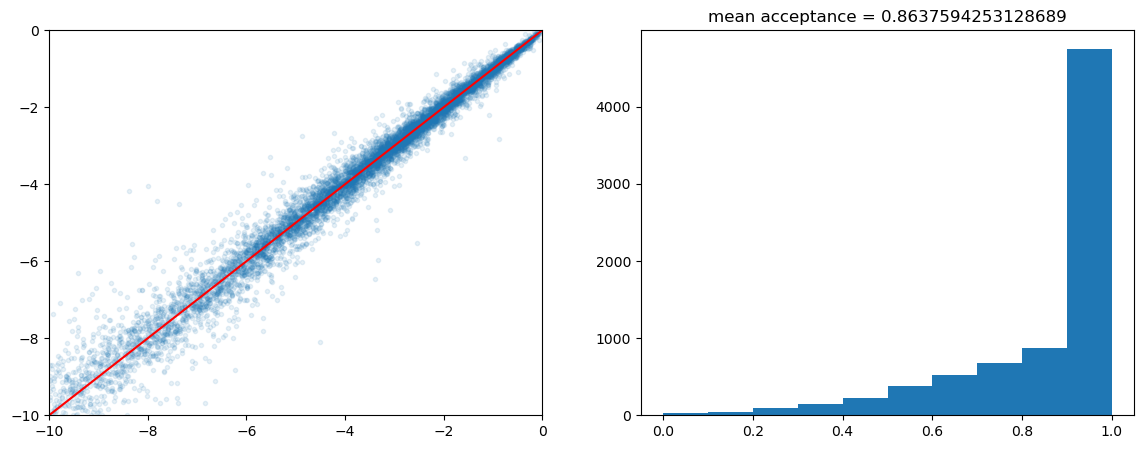

In [64]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Creating a simple neural network in PyTorch


class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, output_size)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader for the training set
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)  # Adjust the batch size

# Create the model
model = Net(X_train.shape[1], y_train.shape[1])

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Decrease the learning rate

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

# Train the model
num_epochs = 50000
best_loss = np.inf
patience, trials = 1000, 0

for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Adjust the learning rate based on the loss
    scheduler.step(loss)

    print('Epoch [{}/{}], Loss: {:.4f}, min Loss reached {:.4f}, stagnating for {} it.'.format(epoch +
          1, num_epochs, loss.item(), best_loss, trials))

    # Early stopping
    if loss.item() < best_loss:
        best_loss = loss.item()
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print(f'Stopping early at epoch {epoch+1}')
            break

# Test the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Convert tensor to numpy array
res_surr = y_pred_tensor.numpy()


# Compute alphas and plot results
plot_results_all(res_surr)
